# Talking Data

The purpose of this project is to use mobile user data to predict the age group of the user.  The age groups are split betweeen either female or male, then from below 23,to above 43.  Here is what it looks for females: F23-, F24-26, F27-28, F29-32, F33-42, F43+. 

The data is from the Chinese company TalkingData. There are several data sets, each a unique csv: gender_age_train, gender_age_test, events, app_events, app_labels, label_categories and phone_brand_device_model.  

In [263]:
#Importing the packages needed for this analysis
from pygeocoder import Geocoder
import pandas as pd
import io
import numpy as np
from sklearn.metrics import log_loss
import pickle
import math
import re
import reverse_geocoder as rg
from datetime import *
from scipy import stats
import dateutil.parser
from IPython.display import display
from sklearn import preprocessing
from googletrans import Translator
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from IPython.core.interactiveshell import InteractiveShell
import goslate
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%config InlineBackend.figure_format = 'png'

plt.rcParams['figure.dpi']= 400

In [264]:
#Connecting to SQL database on an AWS EC2 instance
from sqlalchemy import create_engine
import pandas as pdb
cnx = create_engine('postgresql://djmor@34.234.69.231/djmor')

In [265]:
#Loading in coordinates to fast track reverse geocoding
geo = rg.RGeocoder(mode=2, verbose=True, stream=io.StringIO(open('rg_cities1000.csv', encoding='utf-8').read()))

In [266]:
#List of classification types 
classes = {'F23-':0, 'F24-26':1,'F27-28':2,'F29-32':3, 'F33-42':4, 'F43+':5, 'M22-':6, 'M23-26':7, 'M27-28':8, 'M29-31':9, 'M32-38':10, 'M39+':11}
           
           

In [267]:
#Creating all the data frames
device_brand = pd.read_csv('phone_brand_device_model.csv')
applabeldf = pd.read_csv('app_labels.csv')
labelcat = pd.read_csv('label_categories.csv')
genderdf = pd.read_csv('gender_age_train.csv')
eventsdf = pd.read_csv('~/Documents/events.csv')
appevents = pd.read_csv('~/Documents/app_events.csv')
testdf = pd.read_csv('gender_age_test.csv')

In [268]:
testdf.head()
genderdf.head()
genderdf.shape
len(testdf.device_id.unique())
len(testdf)

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


(74645, 4)

112071

112071

In [269]:
device_brand.shape
device_brand = device_brand.drop_duplicates('device_id',keep='first')
testdf = testdf.drop_duplicates('device_id',keep='first')
device_brand.shape
testdf.shape

(187245, 3)

(186716, 3)

(112071, 1)

In [270]:
#Getting an idea on how each df connects with each other
device_brand.head()
appevents.head()
labelcat.head()
eventsdf.head()
applabeldf.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [271]:
device_brand.shape
appevents.shape
labelcat.shape
eventsdf.shape
applabeldf.shape

(186716, 3)

(32473067, 4)

(930, 2)

(3252950, 5)

(459943, 2)

In [272]:
#Translating Phone brand to English for easier comprehension
translate = {'三星':'samsung','天语':'Ktouch','海信':'hisense','联想':'lenovo','欧比':'obi','爱派尔':'ipair','努比亚':'nubia',\
             '优米':'youmi','朵唯':'dowe','黑米':'heymi','锤子':'hammer','酷比魔方':'koobee','美图':'meitu','尼比鲁':'nibilu','一加':'oneplus','优购':'yougo',\
             '诺基亚':'nokia','金立':'jinli','中兴':'zhongxing','糖葫芦':'candy','中国移动':'ccmc','语信':'yuxin','基伍':'kiwu','青橙':'greeno','华硕':'asus',\
             '夏新':'panosonic','维图':'weitu','艾优尼':'aiyouni','摩托罗拉':'moto','乡米':'xiangmi','米奇':'micky','大可乐':'bigcola',\
             '沃普丰':'wpf','神舟':'hasse','摩乐':'mole','酷派':'kupai','飞秒':'fs','米歌':'mige','富可视':'fks','德赛':'desci','梦米':'mengmi','乐视':'lshi','小杨树':'smallt','纽曼':'newman','邦华':'banghua',\
             'E派':'epai','华为':'Huawei','小米':'xiaomi','魅族':'meizu', '易派':'epai','普耐尔':'pner','欧新':'ouxin','西米':'ximi','海尔':'haier','波导':'bodao','糯米':'nuomi','唯米':'weimi','酷珀':'kupo','谷歌':'google','昂达':'ada','聆韵': 'lingyun'}

In [274]:
#Translating phone brand from Chinese to English

for index, i in enumerate(device_brand['phone_brand']):
    if i in translate:
        device_brand.loc[index,'phone_brand'] = translate[i]


In [ ]:
#Using an offline reverse geocoder to get city and country data, also this takes a long time to run...
counter =0
eventsdf['city'] = ''
tup_ls = []
for i,j in zip(eventsdf['latitude'],eventsdf['longitude']):
        lalong = (i,j)
        tup_ls.append(lalong)




In [ ]:
q_list = geo.query(tup_ls)
name_l = []
cc_l = []
for q in q_list:
    name_l.append(q['name'])
    cc_l.append(q['cc'])

In [ ]:
eventsdf['city'] = name_l
eventsdf['cc'] = cc_l

In [ ]:
#Filling NaN with none for better processing
labelcat.fillna('None', inplace = True)

In [ ]:
#Pulling out Month data
eventsdf['time_dl'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').time())
eventsdf['wkday'] = eventsdf['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d  %H:%M:%S').weekday())

In [ ]:
#Writing a pickle file to save data

with open('eventsdf.pkl', 'wb') as picklefile:
    pickle.dump(eventsdf, picklefile)

In [ ]:
eventsdf.shape

## Merging the Data

This section may become obsolete after I get the SQL database going, but as for now, it exists.***Delete Eventually***

I will be using Inner joins to merge the data frames.  My guess is that both training and test data is in each of the auxilary columns, so I only want the intersection of the training dataframe and the auxilary dataframes.

In this section, I also added some extra data.  I pulled out the datetime string and converted into into a readable datetime object.  The time of day and day of the week may not make much of a difference.  It depends on the culture of the society.

In [388]:
#Loading DF into jupyter notebook
eventsdf = pd.read_pickle('eventsdf.pkl')

In [389]:
def supermerge(dfleft):
    result = pd.merge(dfleft, device_brand, how = 'inner', on = 'device_id')
    result = pd.merge(result, eventsdf, how = 'inner', on = 'device_id')
    result = pd.merge(result, appevents, how = 'inner', on = 'event_id')
    result = pd.merge(result, applabeldf, how = 'inner', on = 'app_id')
    result = pd.merge(result, labelcat, how = 'inner', on = 'label_id')
    return result

In [390]:
traindf = supermerge(genderdf)

In [317]:
testdf = supermerge(testdf)


KeyboardInterrupt: 

In [393]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 441034 entries, 0 to 441033
Data columns (total 11 columns):
group           441034 non-null object
phone_brand     441034 non-null object
device_model    441034 non-null object
event_id        441034 non-null object
city            441034 non-null object
cc              441034 non-null object
time_dl         441034 non-null object
wkday           441034 non-null int64
app_id          441034 non-null object
is_active       441034 non-null int64
category        441034 non-null object
dtypes: int64(2), object(9)
memory usage: 40.4+ MB


In [287]:
testdf.drop(['longitude', 'latitude','label_id', 'timestamp', 'is_installed','device_id'], axis=1, inplace = True)
testdf['app_id'] = testdf['app_id'].apply(lambda x: abs(x))

ValueError: labels ['longitude' 'latitude' 'label_id' 'timestamp' 'is_installed'] not contained in axis

In [392]:
traindf.drop(['gender','age', 'longitude', 'latitude','label_id', 'timestamp', 'is_installed','device_id'], axis=1, inplace = True)
traindf.app_id = traindf.app_id.apply(lambda x: str(x))
traindf.event_id = traindf.event_id.apply(lambda x: str(x))

In [394]:
traindf.columns

Index(['group', 'phone_brand', 'device_model', 'event_id', 'city', 'cc',
       'time_dl', 'wkday', 'app_id', 'is_active', 'category'],
      dtype='object')

In [359]:
traindf.head()
testdf.head()

,group,phone_brand,device_model,event_id,city,cc,time_dl,wkday,app_id,is_active,category
0,F29-32,小米,红米2A,2841769,Takoradi,GH,23:27:40,3,5927333115845830913,1,Property Industry 1.0
1,M39+,samsung,Galaxy Note 2,2787439,Takoradi,GH,20:16:20,6,5927333115845830913,1,Property Industry 1.0
2,M32-38,xiaomi,红米note,1285282,Takoradi,GH,14:31:13,2,5927333115845830913,1,Property Industry 1.0
3,M32-38,xiaomi,红米note,1470830,Takoradi,GH,07:07:01,5,5927333115845830913,0,Property Industry 1.0
4,M32-38,xiaomi,红米note,2328638,Takoradi,GH,12:48:08,1,5927333115845830913,1,Property Industry 1.0


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


## Preprocessing

The data has many categorical variables that we are using, so a little preprocessing is needed.  I will be using OneHotEncoder to do this for me.

In [396]:
from sklearn import preprocessing
import patsy
enc = preprocessing.OneHotEncoder(sparse=False)

In [397]:
def trans(df):
    for column in df.columns:
        if df[column].dtype == type(object):
            le = preprocessing.LabelEncoder()
            df[column] = le.fit_transform(df[column])
            #df[column] = enc.fit_transform(df[column].reshape(len(df[column]),1)).toarray()
    return df

In [ ]:
#OHE lines
"""newdf= enc.fit_transform(traindf)
newdf = pd.DataFrame(newdf)"""

In [ ]:
traindf = trans(traindf)

In [398]:
Dummy_lasso = patsy.dmatrix('phone_brand+device_model+event_id+city+cc+ app_id + category', data=traindf, return_type='dataframe')
traindf = traindf.join(Dummy_lasso)

In [403]:
traindf = traindf.drop(['phone_brand', 'device_model', 'event_id', 'city', 'cc', 'app_id', 'category'], axis=1)

In [404]:
traindf.head()

,group,time_dl,wkday,is_active,Intercept,phone_brand[T.Huawei],phone_brand[T.Ktouch],phone_brand[T.OPPO],phone_brand[T.bodao],phone_brand[T.hammer],...,category[T.table game],category[T.takeaway ordering],category[T.the film],category[T.tourism product],category[T.train],category[T.travel],category[T.unknown],category[T.video],category[T.vitality],category[T.weibo]
0,F29-32,23:27:40,3,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M39+,20:16:20,6,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M32-38,14:31:13,2,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M32-38,07:07:01,5,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M32-38,12:48:08,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# STEP 1: split X and y into training and testing sets
y = traindf['group']
X= traindf.drop(['group'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Classification Analysis

The amount of data in the dataframe will make most of the analysis long.  There are 79 million observations, and even splitting it up will make it hard.  Some of the data is in different countries, so dividing it into subsections such as Country, City and Device Brand may make it easier for analysis.  

In [335]:
# STEP 1: split X and y into training and testing sets
#X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.3, random_state=65)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
logit = LogisticRegression(C=.1, multi_class='multinomial',solver='newton-cg', max_iter = 500)

In [ ]:
logit.fit(X_train, y_train)

In [ ]:
y_pred = logit.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average='micro')

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred)

## Looking at Trees

Below is looking at the Decision Tree and Random Forests classification methods to see how it differs from the analysis above.



In [340]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [341]:
dtree = DecisionTreeClassifier(max_depth=5)
rtree = RandomForestClassifier(max_depth=5)

In [342]:
dmodel = dtree.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [301]:
#Experiement to see if i should try random forests
from sklearn.model_selection import cross_val_score
cross_val_score(dtree, X_train, y_train, cv=10)

array([0.50863102, 0.50442077, 0.50498769, 0.50783831, 0.50560342,
       0.50892365, 0.50678674, 0.50775859, 0.50727267, 0.50662563])

In [302]:
y_tree = dmodel.predict(X_test)

In [303]:
f1_score(y_test, y_tree, average = 'micro')

0.5079018373377875

In [304]:
# confusion matrix
confusion_matrix(y_test,y_tree)

array([[   46,     0,    28,     0,   113,     0,     0,    31,     0,
            0,   658,  1241],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  1213,  2234],
       [    0,     0,   576,     0,    56,     0,     0,   115,     0,
            0,   792,   911],
       [    0,     0,     0,     0,   190,     0,     0,     0,     0,
           18,  2129,  3302],
       [    0,     0,    74,     0,  1321,     0,     0,     4,     0,
            0,  3624,   811],
       [    0,     0,   117,     0,     0,   855,     0,   101,     0,
            0,  2540,  1775],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   543,   345],
       [    0,     0,   108,     0,     0,     6,     0,  3098,     0,
            0,  6645,  3298],
       [    0,     0,    36,     0,    17,     0,     0,    32,     0,
          247,  1620,  4579],
       [    0,     0,   546,     0,   205,     0,     0,    74,     0,
         5224,  9001

In [305]:
rmodel = rtree.fit(X_train, y_train)

In [306]:
y_rtree = rmodel.predict(X_test)
f1_score(y_test, y_rtree, average = 'micro')

0.4872686322376824

Feature ranking:
1. event_id (0.594043)
2. city (0.204079)
3. cc (0.151815)
4. time_dl (0.048103)
5. wkday (0.001434)
6. app_id (0.000333)
7. is_active (0.000193)
8. category (0.000000)


Text(0.5,1,'Feature importances')

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x1b04dc9ac8>,
 <a list of 8 Text xticklabel objects>)

(-1, 8)

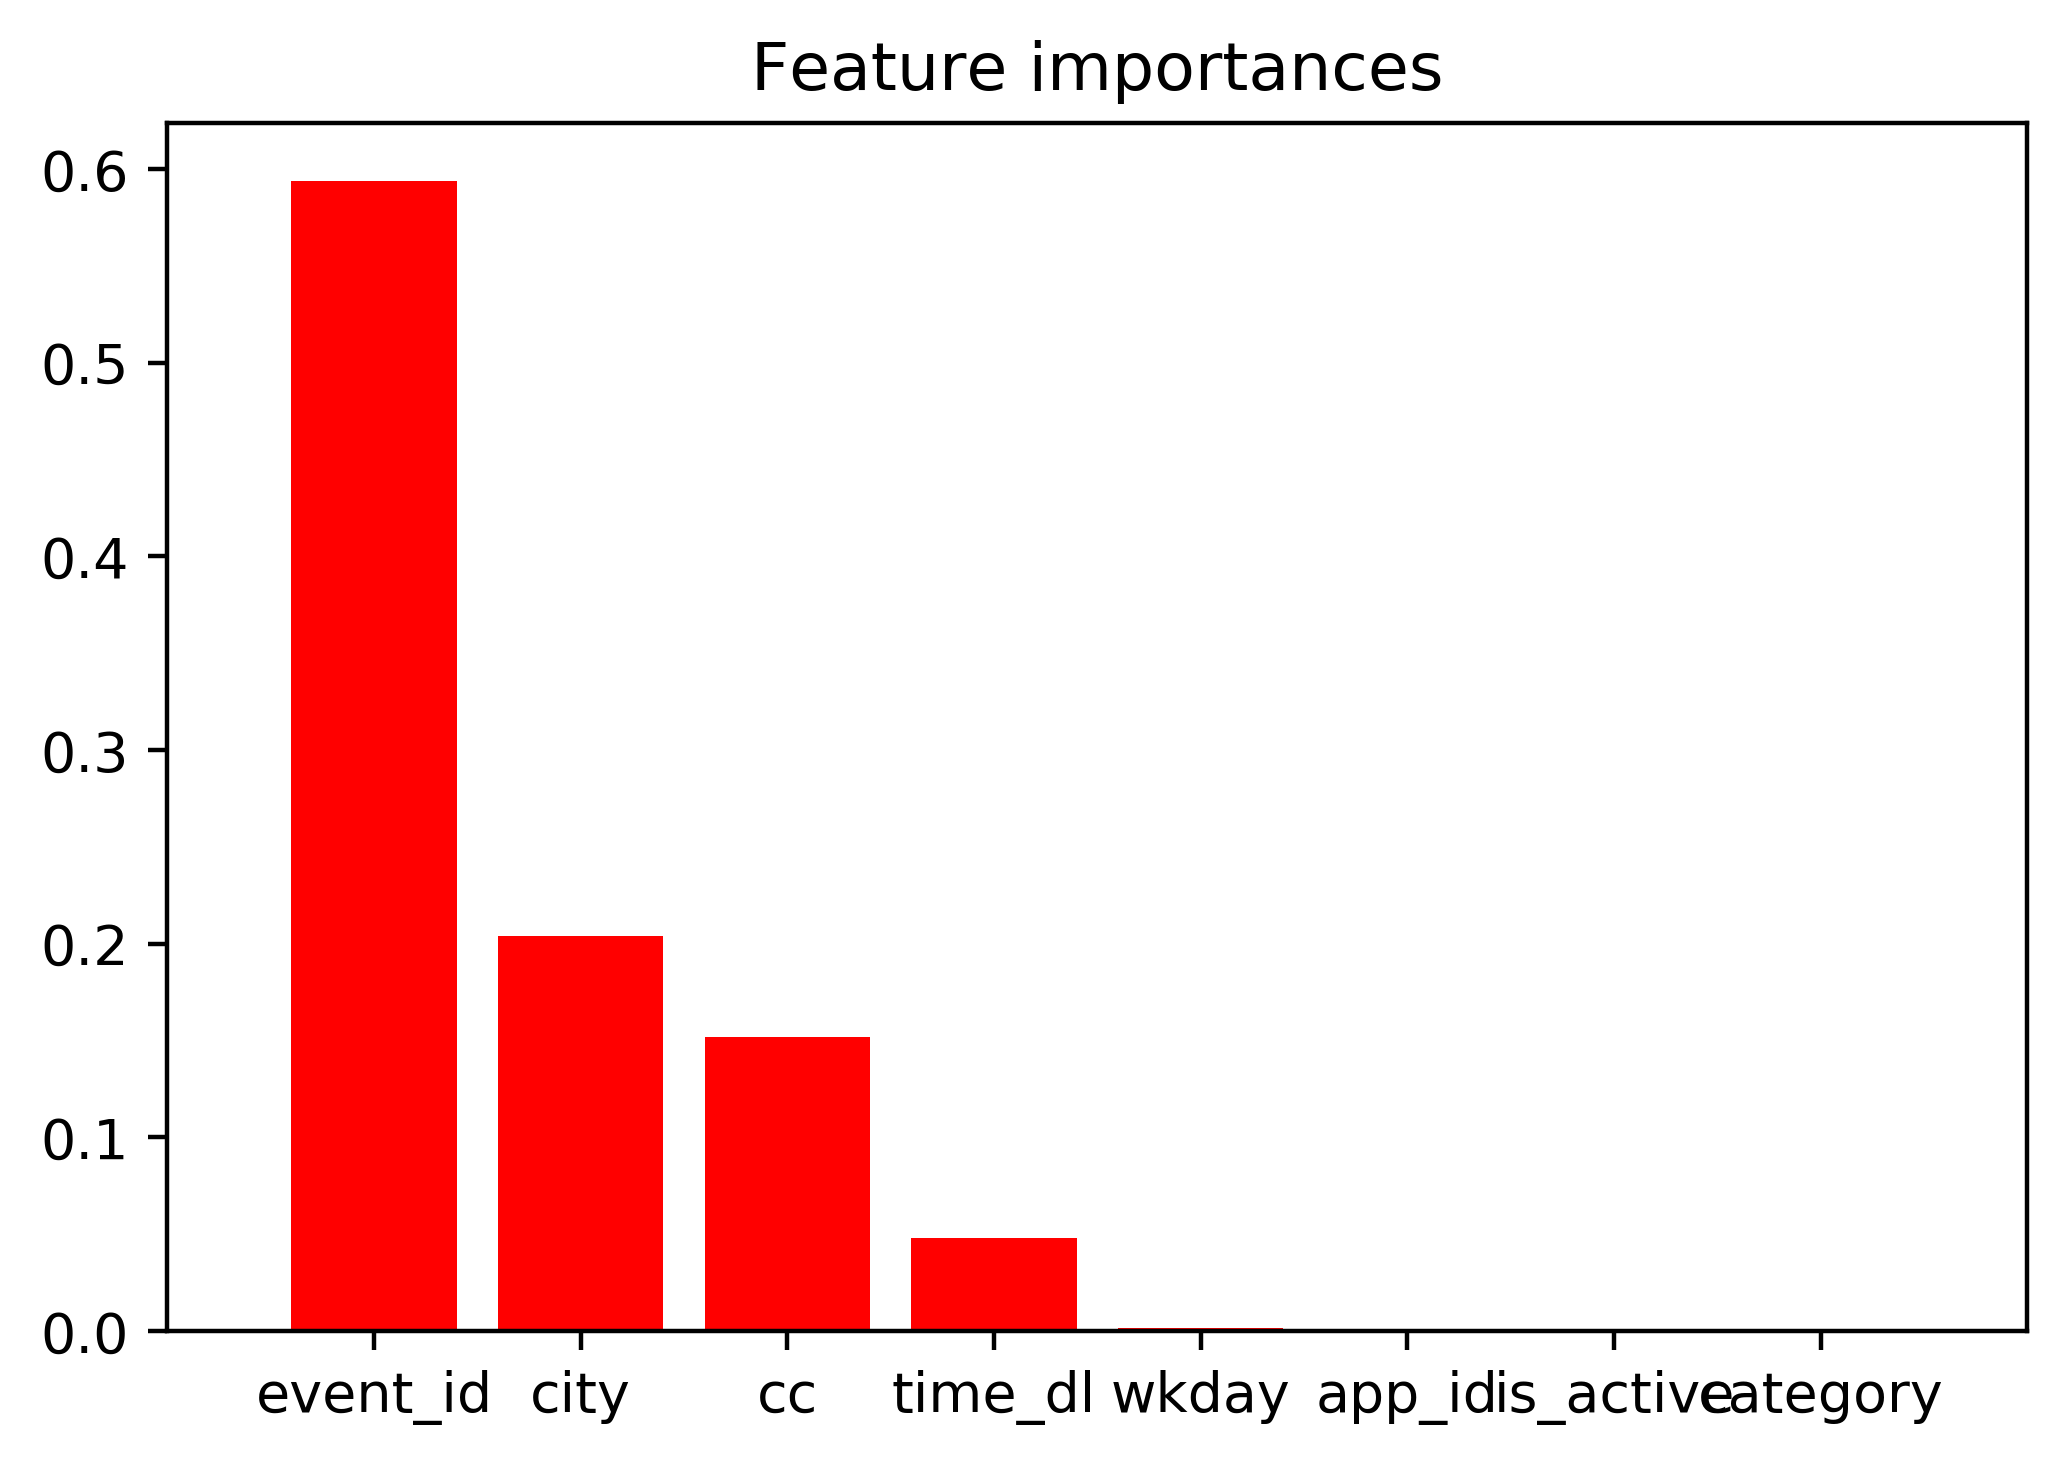

In [307]:
importances = dmodel.feature_importances_
std = np.std([dmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_train.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Feature ranking:
1. event_id (0.531227)
2. city (0.149982)
3. cc (0.122341)
4. time_dl (0.092390)
5. wkday (0.062629)
6. app_id (0.021579)
7. is_active (0.013418)
8. category (0.006434)


Text(0.5,1,'Feature importances')

<Container object of 8 artists>

([<matplotlib.axis.XTick at 0x1a968a3908>,
 <a list of 8 Text xticklabel objects>)

(-1, 8)

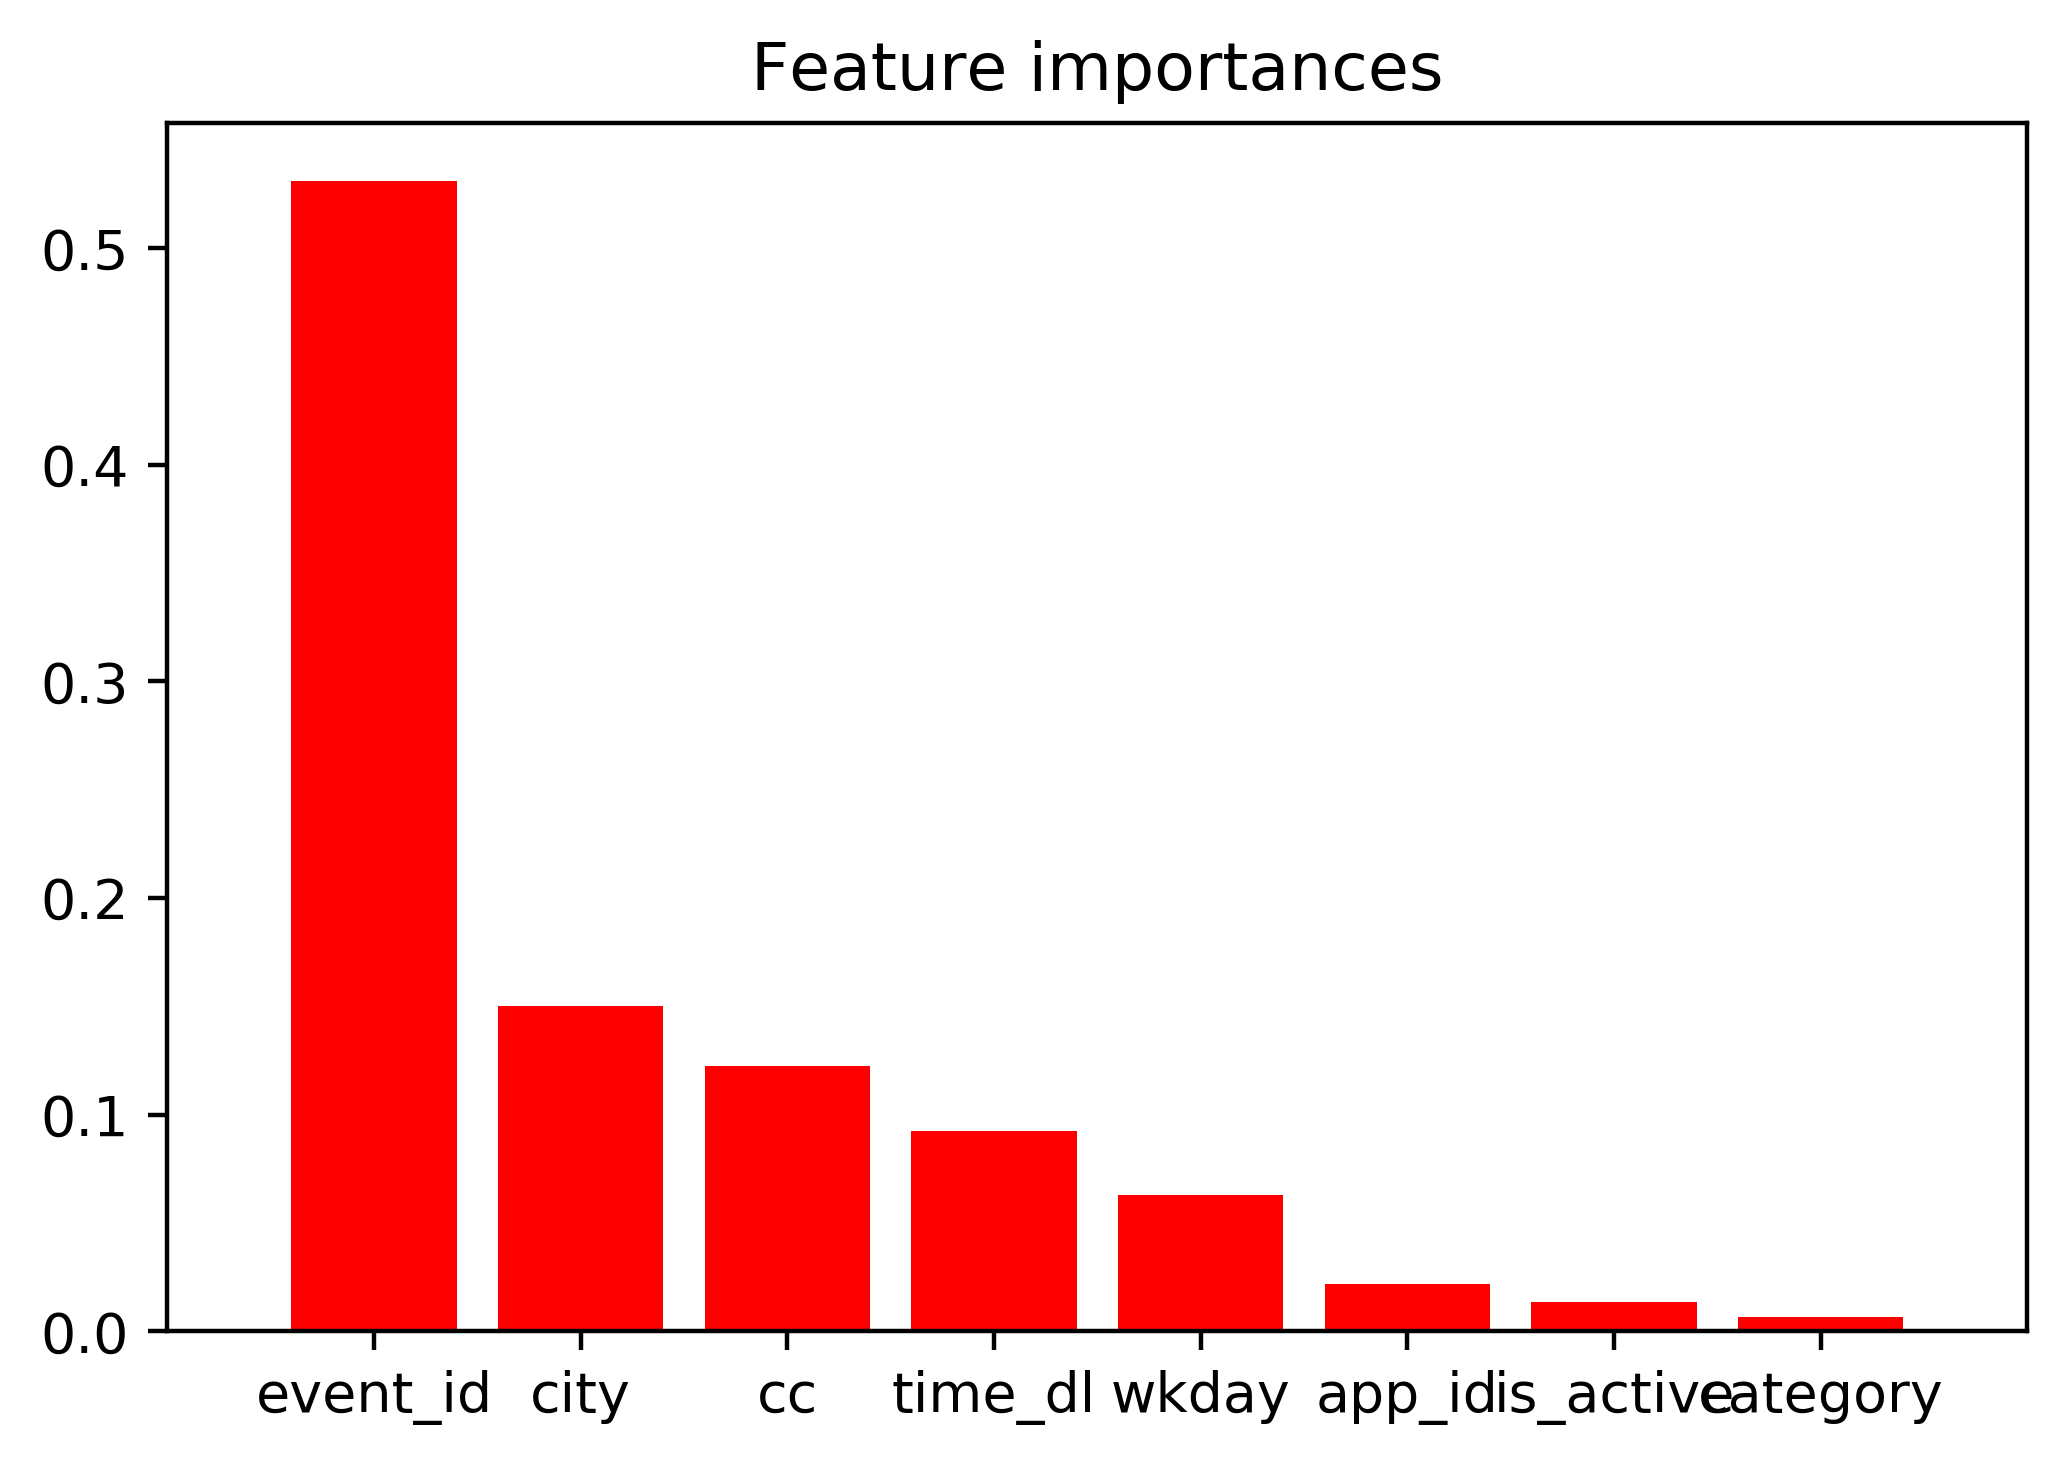

In [256]:
importances = rmodel.feature_importances_
std = np.std([rmodel.feature_importances_ for tree in importances],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for index,f in enumerate(X_train.columns):
    print("%d. %s (%f)" % (index+1 , f, importances[indices[index]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [245]:
from sklearn.ensemble import BaggingClassifier

In [250]:
bagg = BaggingClassifier(RandomForestClassifier(max_depth=5),max_samples=0.5, max_features=0.5)

In [251]:
bagg.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [252]:
y_bagg = bagg.predict(X_test)
f1_score(y_test, y_bagg, average = 'micro')

0.5092849422950473

In [309]:
import seaborn as sns

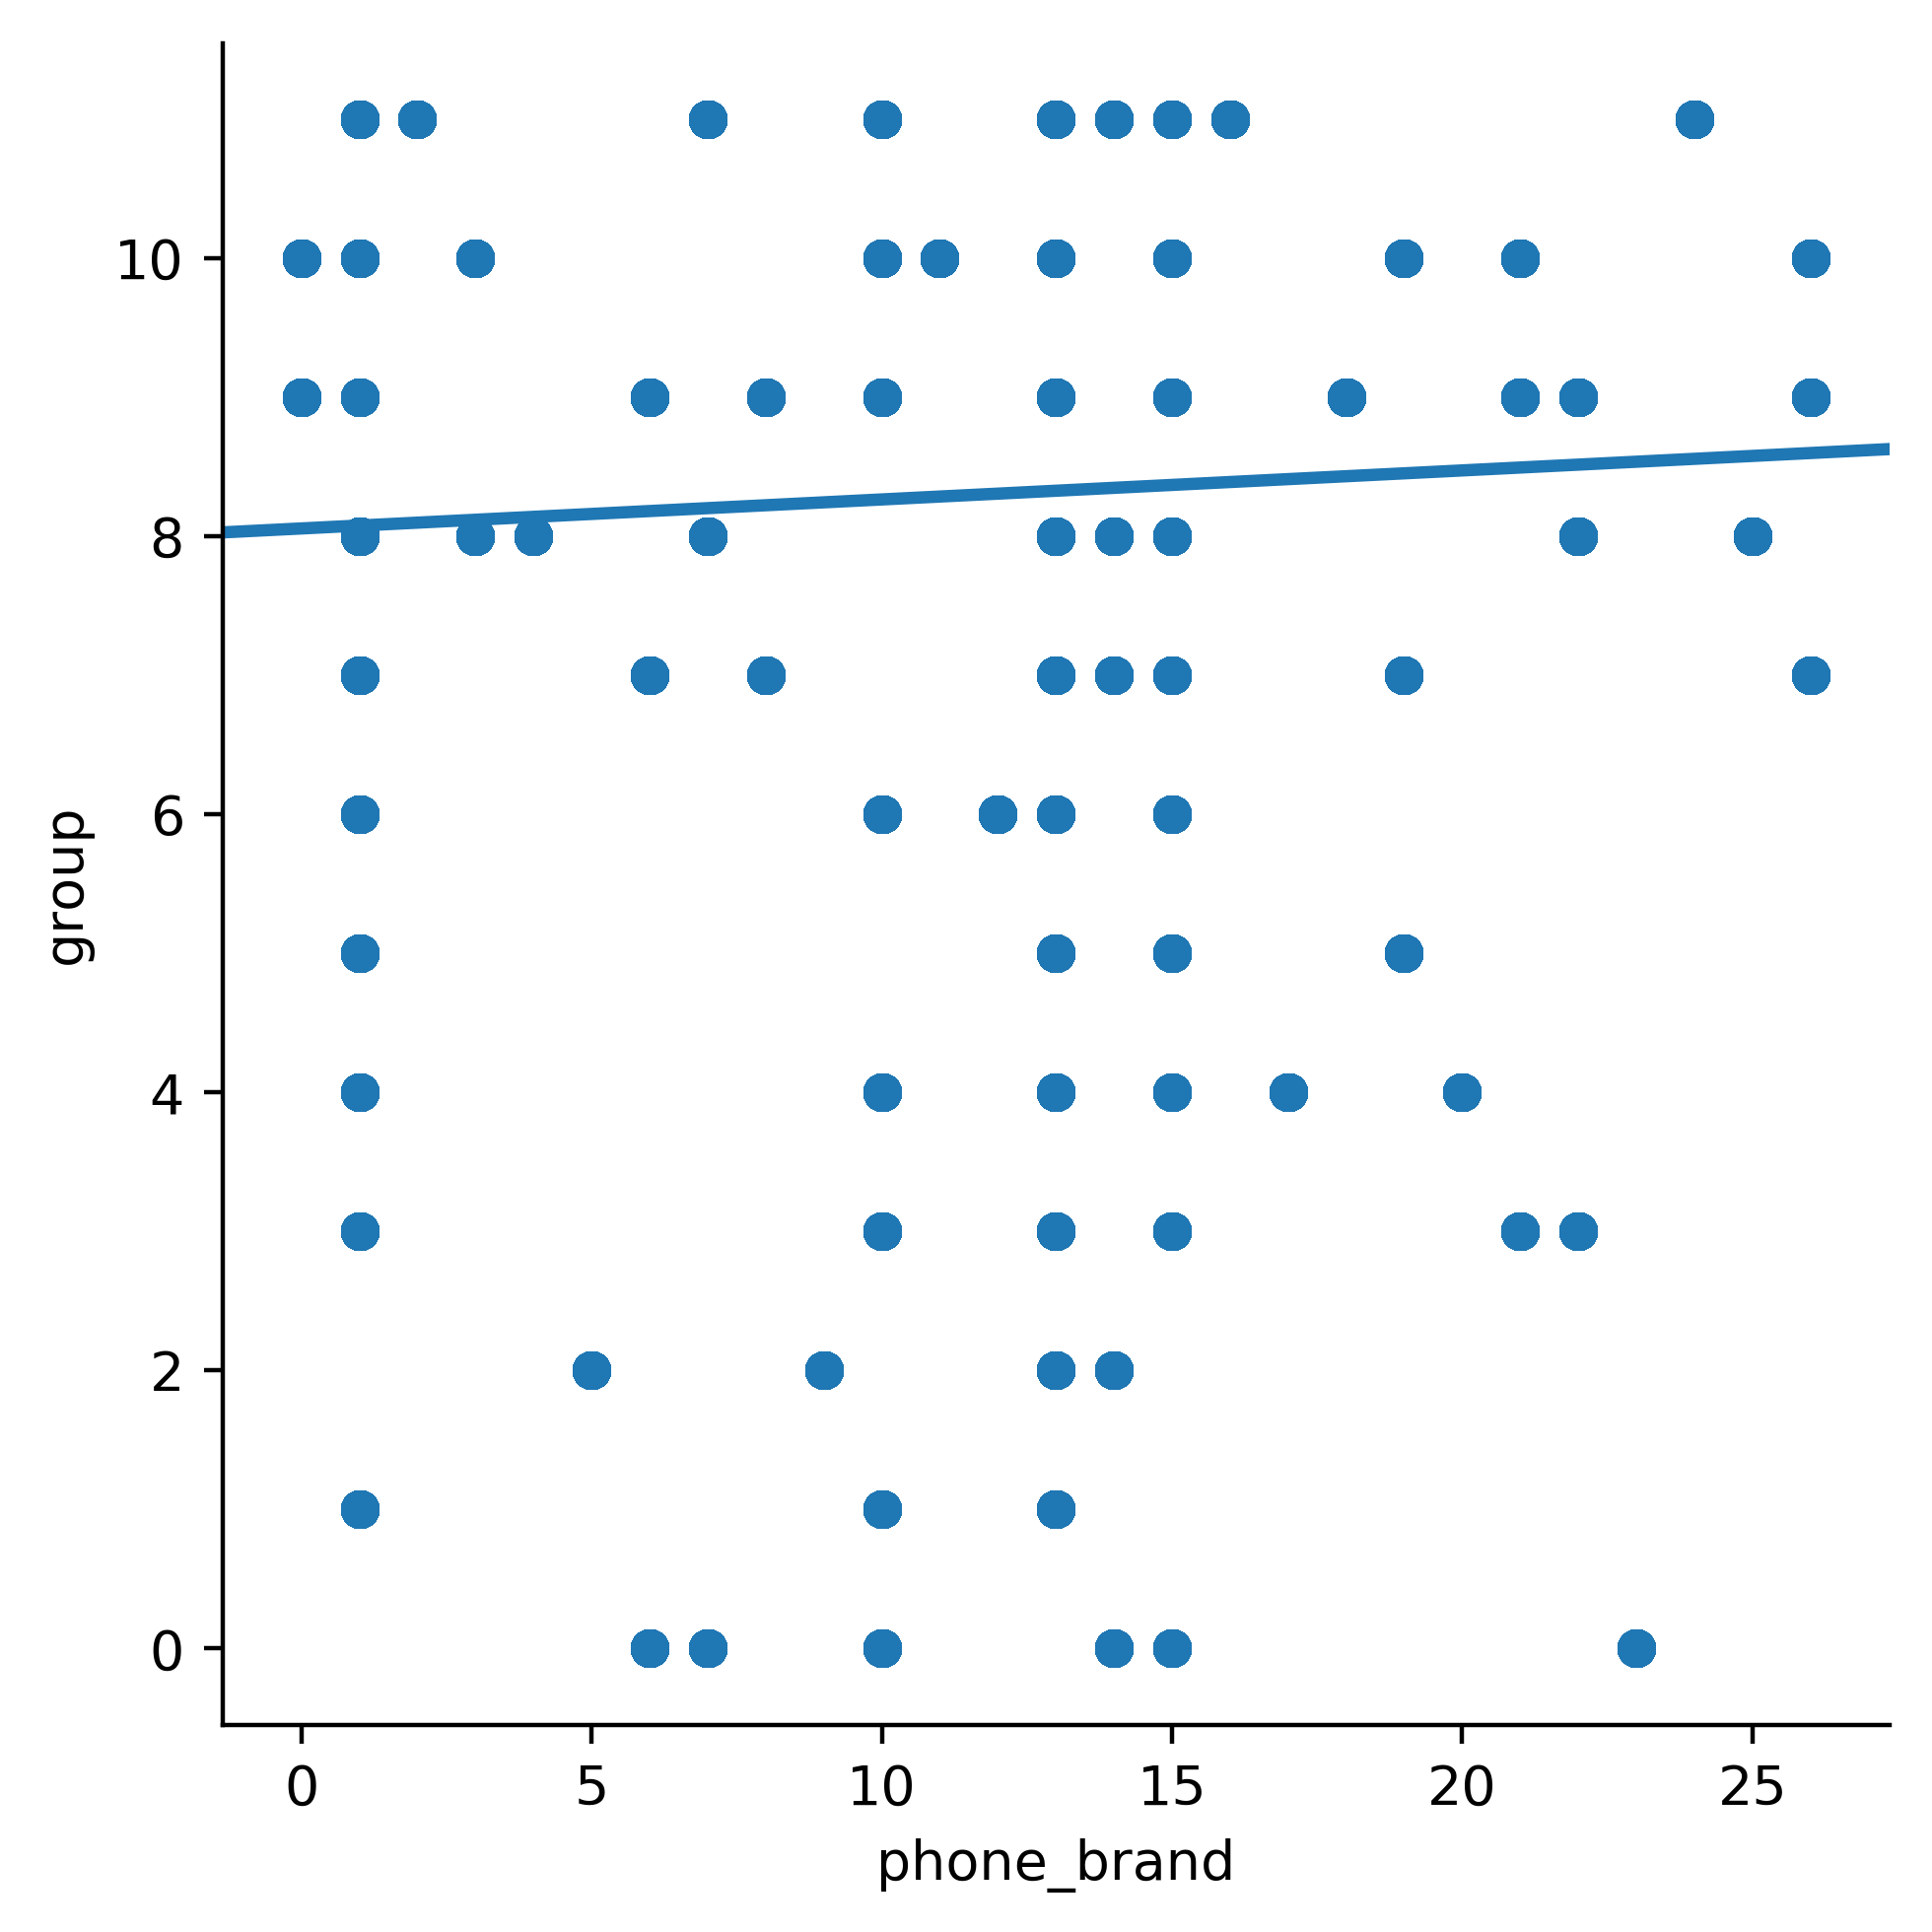

In [310]:
sns.lmplot('phone_brand','group', traindf)